In [26]:
import pandas as pd
import bamboolib as bam
import plotly.express as px
import numpy as np
from datetime import datetime
import re
import statsmodels.api as sm
import seaborn
bam.enable()
url1 = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
url2 = "https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx"
path1 = "./Rt_no_Rolling.csv"
def getExcel(url, sheet, head):
    df = pd.read_excel(url,sheet_name=sheet, header=head)
    df=df.truncate(before=0,after=253)
    return df

df = getExcel(url1, 'Cases by County', 2)
df.keys()
df2 = df.set_index('County Name')

dftesting  = getExcel(url2, 'Total Tests Received', 1)
dftesting.keys()
dft2 = dftesting.set_index('County')

dfrate = pd.read_csv(path1)

dfr2 = dfrate.truncate(47, 191)


Success: the bamboolib extension was enabled successfully. You can disable it via 'bam.disable()'. You will now see a magic bamboolib button when you display your dataframes, for example via 'df'


In [27]:
dft3 = dft2.T.copy()
dft3 = dft3.reset_index()
dft3 = dft3.replace('--', np.nan)
dft3 = dft3.replace('-', np.nan)
dft3 = dft3.fillna(method='ffill')
dft3.columns = [str(column) for column in dft3.columns]
dft3 = dft3.drop(columns=['Borden', 'King', 'Loving'])
dft3 = dft3.drop(columns=['index'])
dft3

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
0,270.0,2.0,282.0,16.0,8.0,4.0,86.0,183.0,0.0,47.0,...,161.0,3438.0,195.0,9.0,249.0,75.0,14.0,311.0,18.0,10.0
1,282.0,2.0,311.0,17.0,9.0,5.0,89.0,185.0,0.0,48.0,...,164.0,3566.0,195.0,9.0,256.0,81.0,14.0,322.0,18.0,10.0
2,297.0,5.0,431.0,15.0,13.0,8.0,81.0,96.0,1.0,53.0,...,213.0,3093.0,209.0,12.0,208.0,54.0,2.0,96.0,21.0,13.0
3,329.0,6.0,434.0,24.0,18.0,8.0,105.0,234.0,1.0,63.0,...,231.0,3231.0,292.0,14.0,265.0,81.0,11.0,269.0,23.0,15.0
4,337.0,6.0,469.0,27.0,20.0,8.0,110.0,253.0,1.0,65.0,...,242.0,3438.0,249.0,16.0,293.0,84.0,12.0,279.0,24.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,25430.0,1283.0,13694.0,1816.0,395.0,294.0,7968.0,4824.0,975.0,1244.0,...,7105.0,69319.0,5740.0,280.0,8481.0,3376.0,831.0,1891.0,3310.0,1730.0
141,25569.0,1286.0,14270.0,1886.0,398.0,294.0,8018.0,4857.0,978.0,1266.0,...,7144.0,69780.0,5800.0,280.0,8668.0,3459.0,835.0,1899.0,3317.0,1740.0
142,25569.0,1286.0,14275.0,1895.0,398.0,294.0,8030.0,4858.0,978.0,1277.0,...,7145.0,69802.0,5802.0,280.0,8668.0,3459.0,835.0,1899.0,3317.0,1740.0
143,25622.0,1298.0,14390.0,1912.0,410.0,297.0,8152.0,4973.0,983.0,1314.0,...,7229.0,70707.0,5906.0,284.0,8992.0,3523.0,934.0,1907.0,3361.0,1770.0


In [28]:
dfr2 = dfr2.fillna(0.0)
dfr2 = dfr2.drop(columns=['Unnamed: 0'])
dfr2

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
47,1.975548,0.136823,1.356446,4.862061,0.000000,1.086830,1.883651,0.533532,0.000000,0.442631,...,1.189610,1.154889,0.697021,0.469520,1.411106,2.073512,0.000000,0.885071,0.636148,0.863450
48,1.606997,0.154499,1.470202,4.953273,0.000000,3.098665,1.254604,0.909277,0.000000,0.463102,...,1.646627,1.652286,0.752975,0.521397,1.240551,3.011652,0.863450,1.086829,0.630104,0.845902
49,1.391547,0.205766,1.327841,4.984994,0.000000,4.630928,1.090494,1.605367,0.000000,1.606480,...,1.630647,1.635291,0.833854,0.632598,1.134778,3.999200,0.845902,1.549332,0.652963,0.885073
50,1.375306,0.331147,1.272316,4.995365,0.000000,5.436085,0.616703,2.642273,0.000000,2.180259,...,1.636604,2.718501,0.897812,0.868327,1.094520,3.429218,0.885073,2.327205,0.757214,1.086830
51,1.494631,0.611119,1.738686,4.998611,0.000000,3.846902,0.623790,3.715679,0.000000,2.980732,...,1.268331,2.922923,0.894982,1.334612,0.625608,2.511234,1.086830,3.297542,0.956388,1.549332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.458415,0.676085,5.556528,0.082536,0.980844,9.908210,3.133568,0.903057,0.773499,12.202994,...,0.127312,0.988381,3.081494,1.377600,0.858090,1.693617,0.813481,1.187160,1.695661,2.151479
188,1.589996,0.647079,4.302819,0.093541,0.828438,9.863354,3.917838,0.814116,1.623221,15.823685,...,0.046339,1.047795,2.616186,1.686363,1.149776,1.632674,0.468538,1.002317,0.977388,2.872991
189,1.205140,0.715151,2.726291,0.099701,0.862771,7.551777,2.955799,0.747824,1.739952,7.986748,...,0.049283,1.045630,1.915387,1.486121,1.248416,1.398292,0.548085,0.966932,0.825056,2.358127
190,1.044572,0.784884,1.798261,0.079199,0.892888,4.183096,2.131393,0.718263,2.019081,3.622533,...,0.062413,1.025998,1.471114,1.358718,1.229269,1.188876,0.623191,0.945506,0.748856,1.941991


In [11]:
dfr2['Anderson'].shape

(145,)

In [29]:
X=list(dfr2['Lubbock'])
Y=list(dft3['Lubbock'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.t_test([1, 0]))
results.summary()

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          1.974e+04   3686.882      5.353      0.000    1.24e+04     2.7e+04


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2821
Date:                Sun, 27 Sep 2020   Prob (F-statistic):              0.596
Time:                        21:27:23   Log-Likelihood:                -1616.3
No. Observations:                 145   AIC:                             3237.
Df Residuals:                     143   BIC:                             3243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.974e+04   3686.882      5.353      0.000    1.24e+04     2.7e+04
x1          1597.2167   3007.423      0.531      0.596   -4347.533    7541.966
==============================================================================
Omnibus:                       19.548   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.143
Skew:                           0.823   Prob(JB):                     6.97e-05
Kurtosis:                       2.321   Cond. No.                         5.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

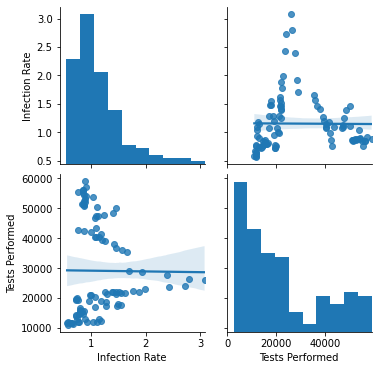

In [32]:
data = pd.DataFrame({'Infection Rate':dfr2['Lubbock'], 'Tests Performed':dft3['Lubbock']})
seaborn.pairplot(data, vars=['Infection Rate', 'Tests Performed'], kind='reg')